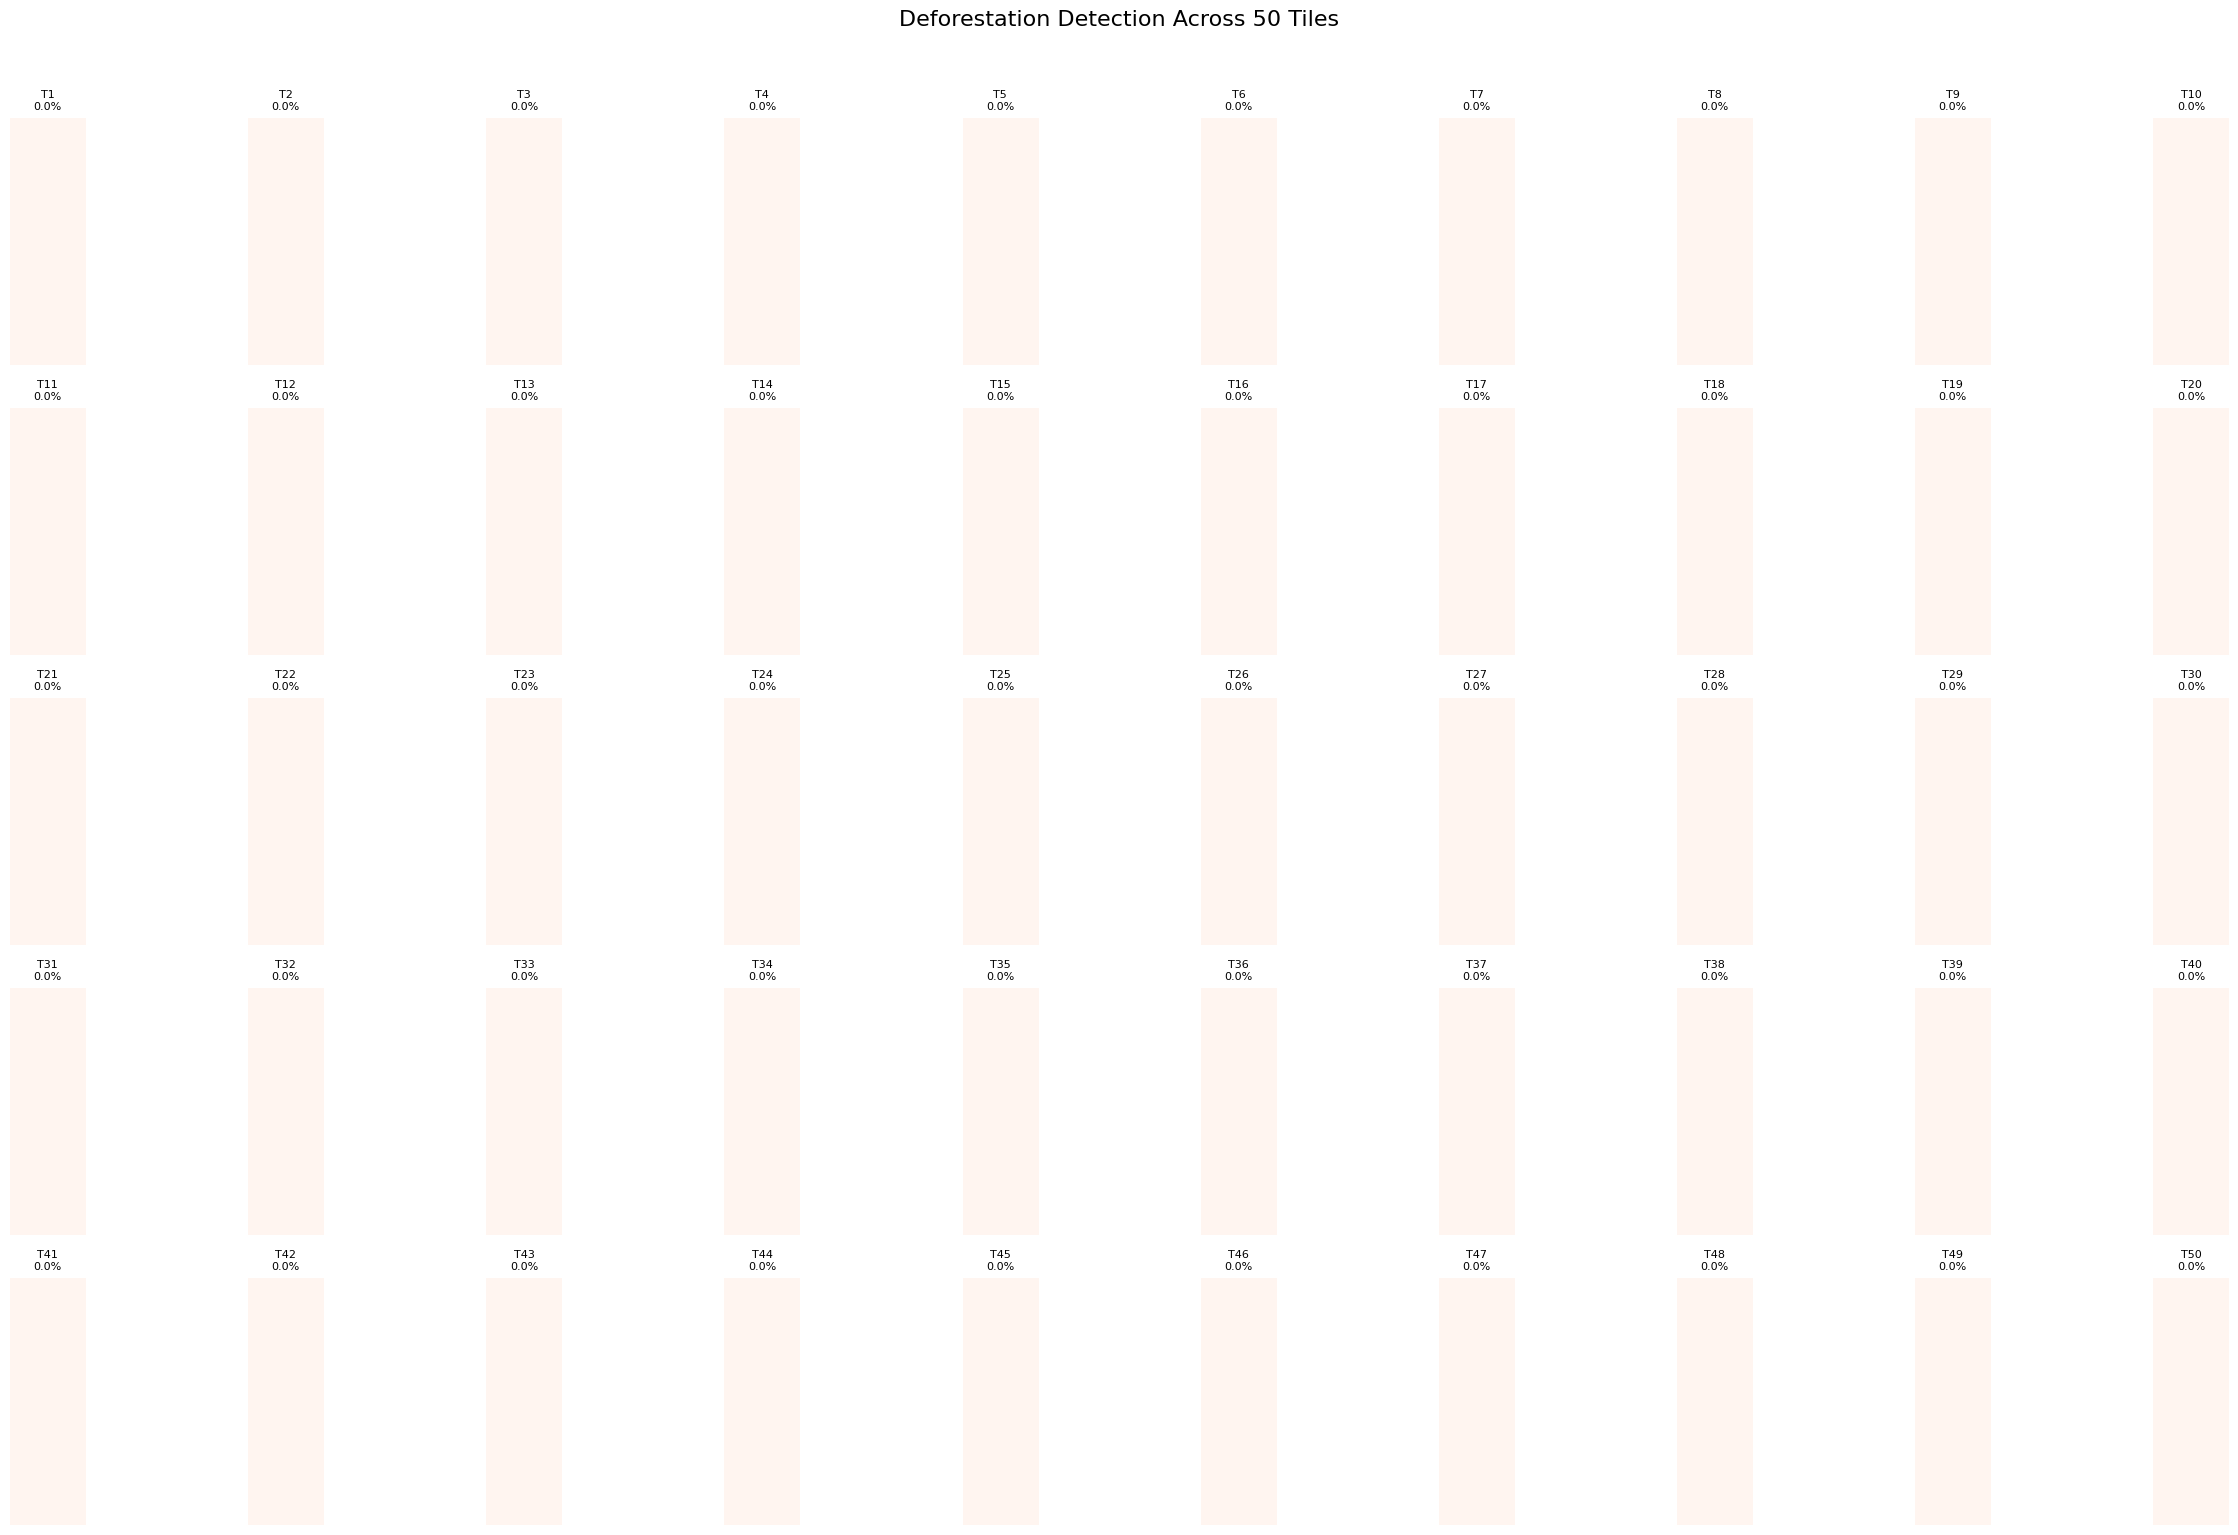


Deforestation Detection Summary:
Total tiles analyzed: 50
Average deforestation: 0.00%
Most deforested tile: 0.00%
Least deforested tile: 0.00%

Deforestation Severity Classification:
High (>30%): 0 tiles
Medium (15-30%): 0 tiles
Low (5-15%): 0 tiles
Minimal (<5%): 50 tiles

Top 5 Most Deforested Tiles:
1. Tile 1: 0.0% at (4100, 400, 4990, 3320)
2. Tile 2: 0.0% at (4990, 400, 5880, 3320)
3. Tile 3: 0.0% at (5880, 400, 6770, 3320)
4. Tile 4: 0.0% at (6770, 400, 7660, 3320)
5. Tile 5: 0.0% at (7660, 400, 8550, 3320)


In [ ]:
import rasterio
import numpy as np
from skimage.morphology import remove_small_objects
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu

def load_liss4_band(path):
    """Load and properly scale LISS-IV band (10-bit or 12-bit)"""
    with rasterio.open(path) as src:
        band = src.read(1)
        max_val = 1023 if band.max() <= 1023 else 4095
        return band.astype('float32') / max_val

# Load bands
green = load_liss4_band('BAND2.tif')  # Green (0.52-0.59µm)
red = load_liss4_band('BAND3.tif')    # Red (0.62-0.68µm)
nir = load_liss4_band('BAND4.tif')    # NIR (0.77-0.86µm)

# Define ROI
x_start, x_end = 4100, 13000
y_start, y_end = 400, 15000

# Extract ROI
green_roi = green[y_start:y_end, x_start:x_end]
red_roi = red[y_start:y_end, x_start:x_end]
nir_roi = nir[y_start:y_end, x_start:x_end]

def detect_deforestation(green_tile, nir_tile, red_tile, min_size=50):
    """
    Detect deforested areas using:
    - NDVI (vegetation index)
    - Brightness (bare soil is brighter)
    """
    # Calculate NDVI (Normalized Difference Vegetation Index)
    ndvi = (nir_tile - red_tile) / (nir_tile + red_tile + 1e-10)
    
    # Calculate brightness (bare soil is brighter than vegetation)
    brightness = (green_tile + nir_tile + red_tile) / 3
    
    # Dynamic threshold for NDVI (vegetation threshold)
    try:
        veg_thresh = threshold_otsu(ndvi[(ndvi > -1) & (ndvi < 1)]) * 0.3
    except:
        veg_thresh = 0.3  # Fallback threshold
    
    # Brightness threshold for bare soil
    brightness_thresh = 0.25
    
    # Potential deforestation areas
    deforest_mask = (ndvi < veg_thresh) & (brightness > brightness_thresh)
    
    # Remove small objects
    return remove_small_objects(deforest_mask, min_size=min_size), ndvi, brightness

def scale_for_display(img, percentile=98):
    """Enhanced contrast stretching for visualization"""
    img = np.nan_to_num(img, nan=0.0)
    p2, p98 = np.percentile(img[img > 0], (2, percentile))
    return np.clip((img - p2) / (p98 - p2), 0, 1)

# Process 50 tiles (5 rows x 10 columns)
rows, cols = 5, 10
tile_height = green_roi.shape[0] // rows
tile_width = green_roi.shape[1] // cols

deforest_percentages = []
tile_info = []

# Create a single figure for all 50 tiles
plt.figure(figsize=(25, 15))
plt.suptitle('Deforestation Detection Across 50 Tiles', fontsize=16, y=1.02)

for i in range(rows):
    for j in range(cols):
        tile_idx = i * cols + j + 1
        
        # Extract tile
        y1, y2 = i * tile_height, (i + 1) * tile_height
        x1, x2 = j * tile_width, (j + 1) * tile_width
        green_tile = green_roi[y1:y2, x1:x2]
        red_tile = red_roi[y1:y2, x1:x2]
        nir_tile = nir_roi[y1:y2, x1:x2]
        
        # Detect deforestation
        deforest_mask, ndvi, brightness = detect_deforestation(green_tile, nir_tile, red_tile)
        deforest_pct = np.sum(deforest_mask) / deforest_mask.size * 100
        
        # Store results
        deforest_percentages.append(deforest_pct)
        tile_info.append({
            'tile': tile_idx,
            'deforest_pct': deforest_pct,
            'coords': (x_start + x1, y_start + y1, x_start + x2, y_start + y2)
        })
        
        # Plot each tile in the grid
        plt.subplot(rows, cols, tile_idx)
        plt.imshow(deforest_mask, cmap='Reds')
        plt.title(f'T{tile_idx}\n{deforest_pct:.1f}%', fontsize=8)
        plt.axis('off')

plt.tight_layout()
plt.show()

# Summary statistics
print("\nDeforestation Detection Summary:")
print(f"Total tiles analyzed: {rows*cols}")
print(f"Average deforestation: {np.mean(deforest_percentages):.2f}%")
print(f"Most deforested tile: {np.max(deforest_percentages):.2f}%")
print(f"Least deforested tile: {np.min(deforest_percentages):.2f}%")

# Classification
high_deforest = sum(1 for x in deforest_percentages if x > 30)
medium_deforest = sum(1 for x in deforest_percentages if 15 < x <= 30)
low_deforest = sum(1 for x in deforest_percentages if 5 < x <= 15)
minimal_deforest = sum(1 for x in deforest_percentages if x <= 5)

print("\nDeforestation Severity Classification:")
print(f"High (>30%): {high_deforest} tiles")
print(f"Medium (15-30%): {medium_deforest} tiles")
print(f"Low (5-15%): {low_deforest} tiles")
print(f"Minimal (<5%): {minimal_deforest} tiles")

# Top 5 most deforested tiles
sorted_tiles = sorted(tile_info, key=lambda x: x['deforest_pct'], reverse=True)
print("\nTop 5 Most Deforested Tiles:")
for i, tile in enumerate(sorted_tiles[:5], 1):
    print(f"{i}. Tile {tile['tile']}: {tile['deforest_pct']:.1f}% at {tile['coords']}")

# Optional: Save results to CSV
import pandas as pd
df = pd.DataFrame(tile_info)
df.to_csv('deforestation_results.csv', index=False)